# Load Surface Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import argparse
import torch
import sys
import torch
import os
import glob
import numpy as np
from PIL import Image
from torchvision import transforms
from tqdm.notebook import tqdm
sys.path.append('../')
import utils


def randomresize(x, resize_min, resize_max):
    w, h = x.size
    resize_factor = resize_min + (resize_max - resize_min) * np.random.random()
    return transforms.functional.resize(x, (int(w * resize_factor), int(h * resize_factor)), Image.BILINEAR)


torch.manual_seed(0)
transform = transforms.Compose([transforms.Lambda(lambda x: randomresize(x, 0.785, 0.785)), transforms.ToTensor()])
filenames = sorted(glob.glob("../images/clean-images-for-paper/*.tif"))
images = torch.cat([transform(Image.open(x).copy()) for x in filenames], dim=0)

/ext3/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


In [2]:
images.shape

torch.Size([4, 727, 687])

# Calculate Metrics

In [3]:
from tqdm.notebook import tqdm
import scipy
from skimage.feature import blob_log
from skimage.draw import circle
from scipy.spatial import Delaunay
import numpy as np


def get_atom_mask(data, min_sigma=2, max_sigma=20, threshold=0.03, num_sigma=10):
    temp = data.copy()
    temp[360:] = temp[:100] = temp[:, :90] = temp[:, 580:] = 0.45

    blobs = blob_log(temp, min_sigma=min_sigma, max_sigma=max_sigma, num_sigma=num_sigma, threshold=threshold)
    blobs[:, 2] = blobs[:, 2] * np.sqrt(2)
    blobs = blobs[blobs[:, 2] > 9]

    atoms = np.zeros_like(data)
    for blob in blobs:
        y, x, r = blob
        xx, yy = circle(*blob)
        for xxx, yyy in zip(xx, yy):
            if xxx < data.shape[0] and yyy < data.shape[1]:
                atoms[xxx, yyy] = 1
    return atoms, blobs


def compute_ratio(noisy_image, denoised_image, mask, vaccum_lambda=0.45):    
    blob_sizes = mask.sum(axis=(1, 2))
    ix, iy, iz = mask.nonzero()
    
    # collect all noisy pixels in each blobs for vectorization
    # N x 1 where N is the total number of pixels in all blobs
    noisy_flatten = noisy_image[(iy, iz)]
    
    # average denoised intensities within each blob
    # H x W where H and W are image height and width
    blob_means = (mask * denoised_image).sum(axis=(1, 2)) / blob_sizes
    blob_means = (mask * blob_means[:, None, None]).sum(axis=0)
    
    # compute sums of log likelihood with different Poisson means: blob average, pixel-level intensiy, and vacuum intensity
    # B x 1 where B is the number of blobs
    mean_llh, pixel_llh, vacuum_llh = np.zeros(len(mask)), np.zeros(len(mask)), np.zeros(len(mask))
    np.add.at(mean_llh, ix, scipy.stats.poisson(blob_means[(iy, iz)]).logpmf(noisy_flatten))
    np.add.at(pixel_llh, ix, scipy.stats.poisson(denoised_image[(iy, iz)]).logpmf(noisy_flatten))
    np.add.at(vacuum_llh, ix, scipy.stats.poisson(vaccum_lambda).logpmf(noisy_flatten))
    
    # normalize those sums by blob sizes
    pixel_llh = pixel_llh / blob_sizes
    vacuum_llh = vacuum_llh / blob_sizes
    mean_llh = mean_llh / blob_sizes
    
    # return log likelihood ratios
    return pixel_llh - vacuum_llh, mean_llh - vacuum_llh


def alpha_shape(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add an edge between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges


def find_boundaries(denoised_blobs, alpha=40):
    # points = denoised.shape[0] - denoised_blobs[:, [1, 0]]
    points = denoised_blobs[:, [1, 0]]
    edges = alpha_shape(points, alpha=alpha, only_outer=True)
    edges = [(x, y) for (x, y) in edges if points[x][1] < 330 or points[y][1] < 330]
    surface = list(set(e[0] for e in edges) | set(e[1] for e in edges))
    rest = list(set(range(len(points))) - set(surface))
    return surface, rest, points, edges

In [4]:
ref = images[1].numpy()
add_atom = images[0].numpy()
remove_atom1 = images[2].numpy()
remove_atom2 = images[3].numpy()

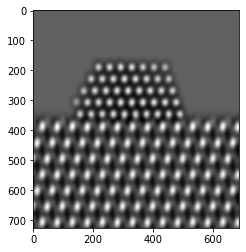

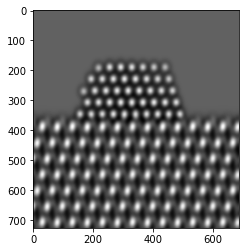

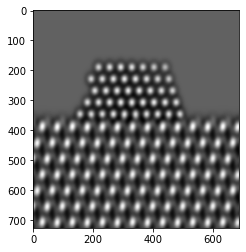

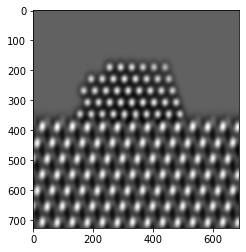

In [5]:
for i in range(4):
    plt.imshow(images[i], cmap='gray')
    plt.show()

<ipython-input-3-f0b11bfbb00e>:20: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  xx, yy = circle(*blob)


41.89313127732042
0.9461618758596408


<ipython-input-3-f0b11bfbb00e>:20: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  xx, yy = circle(*blob)


41.89192490103853
0.9483351811230696


<ipython-input-3-f0b11bfbb00e>:20: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  xx, yy = circle(*blob)


41.81655268392734
0.9483695874984653


<ipython-input-3-f0b11bfbb00e>:20: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  xx, yy = circle(*blob)


41.836849843426116
0.9486386803964719


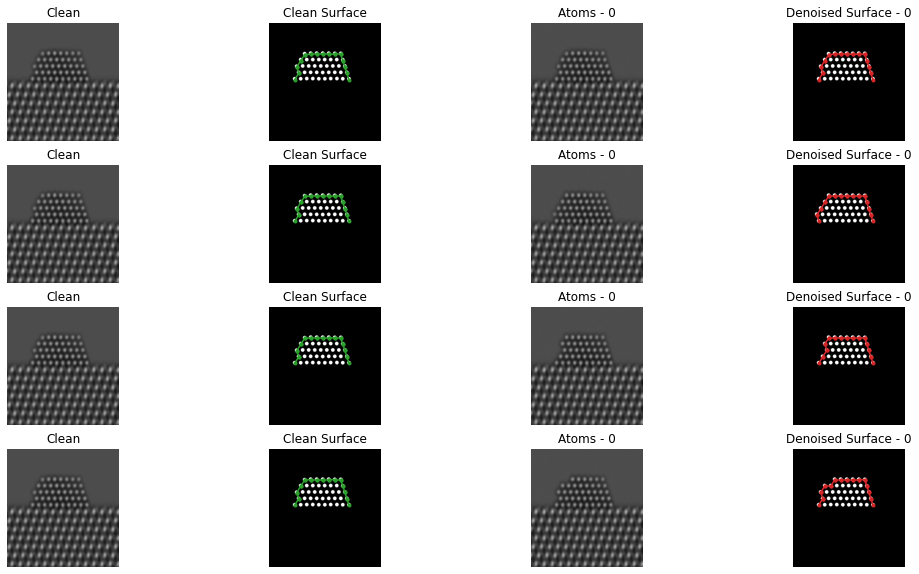

In [6]:
fig, axes = plt.subplots(4, 4, figsize=(18, 10), sharex=True, sharey=True)

noise_std = 0

for i, denoised in enumerate([ref + np.random.randn(*ref.shape)*(2.05/255), 
                              add_atom + np.random.randn(*ref.shape)*(2/255), 
                              remove_atom1 + np.random.randn(*ref.shape)*(1.99/255), 
                              remove_atom2 + np.random.randn(*ref.shape)*(1.99/255), ]):
    
    clean_atoms, clean_blobs = get_atom_mask(ref, min_sigma=8, max_sigma=8, num_sigma=1, threshold=0.02)
    clean_surface, clean_rest, clean_points, clean_edges = find_boundaries(clean_blobs)

    denoised_atoms_0, denoised_blobs_0 = get_atom_mask(denoised, min_sigma=8, max_sigma=8, num_sigma=1, threshold=0.0145)
    denoised_surface_0, denoised_rest_0, denoised_points_0, denoised_edges_0 = find_boundaries(denoised_blobs_0)

    axes[i, 0].imshow(ref, cmap="gray", vmax=.8, vmin = 0.3)
    axes[i, 0].set_title(f"Clean")

    axes[i, 1].imshow(clean_atoms, cmap="gray")
    for edge in clean_edges:
        axes[i, 1].plot(clean_points[edge, 0], clean_points[edge, 1], ".-", c="C2")
    axes[i, 1].set_title(f"Clean Surface")

    axes[i, 2].imshow(denoised, cmap="gray",vmax=.8, vmin = 0.3)
    axes[i, 2].set_title(f"Atoms - 0")

    axes[i, 3].imshow(denoised_atoms_0, cmap="gray")
    for edge in denoised_edges_0:
        axes[i, 3].plot(denoised_points_0[edge, 0], denoised_points_0[edge, 1], ".-", c="C3")
    axes[i, 3].set_title(f"Denoised Surface - 0")
    
    print(utils.psnr(torch.Tensor(ref)[None, None], torch.Tensor(denoised)[None, None]))
    print(utils.ssim(torch.Tensor(ref)[None, None], torch.Tensor(denoised)[None, None]))

for ax in axes.flatten():
    ax.axis("off")

In [7]:
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns


def calculate_metrics(clean_set, denoised_set, theshold=100, defocus = None):
    dist = np.sum((clean_set[:, None] - denoised_set) ** 2, axis=-1)
    clean_missing = np.where(dist.min(axis=1) > theshold)[0]
    denoised_extra = np.where(dist.min(axis=0) > theshold)[0]
    shared = np.where(dist.min(axis=1) <= theshold)[0]
    
    precision = 1.0 * len(shared) / len(denoised_set)
    recall = 1.0 * len(shared) / len(clean_set)
    f1 = 2.0 * len(shared) / (len(clean_missing) + len(denoised_extra) + 2 * len(shared))
    jaccard = 1.0 * len(shared) / (len(clean_missing) + len(denoised_extra) + len(shared))
    return {'precision': precision, 'recall': recall, 'f1': f1, 'jaccard': jaccard, 'defocus': defocus}

<ipython-input-3-f0b11bfbb00e>:20: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  xx, yy = circle(*blob)


PSNR:  41.90002063117612
{'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'jaccard': 1.0, 'defocus': 0}


<ipython-input-3-f0b11bfbb00e>:20: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  xx, yy = circle(*blob)
<ipython-input-3-f0b11bfbb00e>:20: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  xx, yy = circle(*blob)


PSNR:  41.890045869121764
{'precision': 0.9333333333333333, 'recall': 0.9333333333333333, 'f1': 0.9333333333333333, 'jaccard': 0.875, 'defocus': 0}
PSNR:  41.84732231934121
{'precision': 0.9333333333333333, 'recall': 0.9333333333333333, 'f1': 0.9333333333333333, 'jaccard': 0.875, 'defocus': 0}
PSNR:  41.836627539080354
{'precision': 0.9333333333333333, 'recall': 0.9333333333333333, 'f1': 0.9333333333333333, 'jaccard': 0.875, 'defocus': 0}


<ipython-input-3-f0b11bfbb00e>:20: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  xx, yy = circle(*blob)


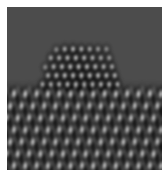

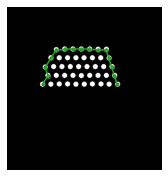

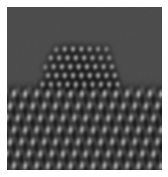

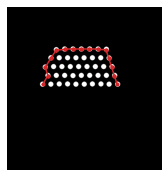

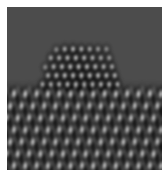

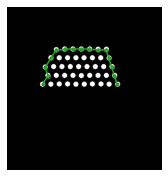

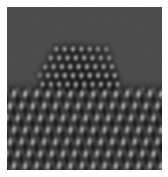

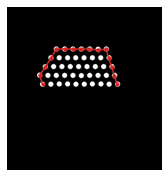

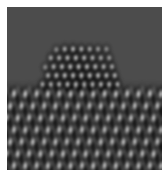

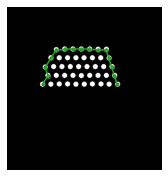

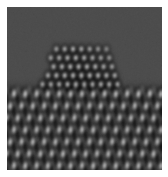

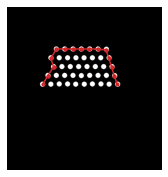

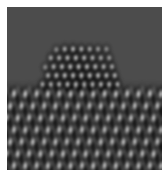

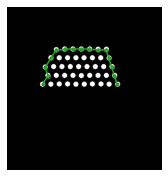

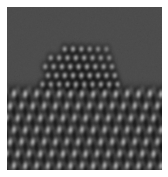

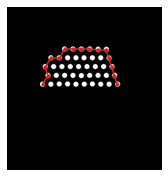

In [8]:
for i, (key, denoised) in enumerate(
                                zip(['whole', 'add', 'remove1', 'remove2'], 
                                    [ref + np.random.randn(*ref.shape)*(2.05/255), 
                              add_atom + np.random.randn(*ref.shape)*(2/255), 
                              remove_atom1 + np.random.randn(*ref.shape)*(1.99/255), 
                              remove_atom2 + np.random.randn(*ref.shape)*(1.99/255)] ) ):
    
    clean_atoms, clean_blobs = get_atom_mask(ref, min_sigma=8, max_sigma=8, num_sigma=1, threshold=0.02)
    clean_surface, clean_rest, clean_points, clean_edges = find_boundaries(clean_blobs)

    denoised_atoms_0, denoised_blobs_0 = get_atom_mask(denoised, min_sigma=8, max_sigma=8, num_sigma=1, threshold=0.0145)
    denoised_surface_0, denoised_rest_0, denoised_points_0, denoised_edges_0 = find_boundaries(denoised_blobs_0)


    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.imshow(ref, cmap="gray", vmax=.8, vmin = 0.3)
    ax.axis("off")
    ax.set_xticks([])
    ax.set_yticks([])
#     fig.savefig(f'../images/paper-fig/clean.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.imshow(clean_atoms, cmap="gray")
    for edge in clean_edges:
        ax.plot(clean_points[edge, 0], clean_points[edge, 1], ".-", c="C2")
    ax.axis("off")
    ax.set_xticks([])
    ax.set_yticks([])
#     fig.savefig(f'../images/paper-fig/clean_surface.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.imshow(denoised, cmap="gray",vmax=.8, vmin = 0.3)
    ax.axis("off")
    ax.set_xticks([])
    ax.set_yticks([])
#     fig.savefig(f'../images/paper-fig/{key}.pdf', dpi=300, bbox_inches='tight', pad_inches=0)


    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.imshow(denoised_atoms_0, cmap="gray")
    for edge in denoised_edges_0:
        ax.plot(denoised_points_0[edge, 0], denoised_points_0[edge, 1], ".-", c="C3")
    ax.axis("off")
    ax.set_xticks([])
    ax.set_yticks([])
#     fig.savefig(f'../images/paper-fig/{key}_surface.pdf', dpi=300, bbox_inches='tight', pad_inches=0)
    
    print('PSNR: ', utils.psnr(torch.Tensor(ref)[None, None], torch.Tensor(denoised)[None, None]).item() )
    
    print(calculate_metrics(clean_blobs[clean_surface], 
                             denoised_blobs_0[denoised_surface_0], 
                             defocus = 0) )

# Load Trained Model

In [9]:
import models
from torch.serialization import default_restore_location


def load_model(checkpoint_path, device="cuda" if torch.cuda.is_available() else "cpu"):
    state_dict = torch.load(checkpoint_path, map_location=lambda s, l: default_restore_location(s, "cpu"))
    args = argparse.Namespace(**{**vars(state_dict["args"])})
    model = models.build_model(args).to(device)
    model.load_state_dict(state_dict["model"][0])
    model.eval()
    return model


checkpoint_path = "../checkpoints/unet-128-big.pt"
model = load_model(checkpoint_path)

In [10]:
R = 5
torch.manual_seed(0)
N, H, W = list(images.shape)
clean = images.detach().cpu().numpy().astype(np.float32)
noisy = np.zeros((N, R, H, W), dtype=np.float32)
denoised = np.zeros((N, R, H, W), dtype=np.float32)
file_basename = [None for _ in range(N)]

for i in tqdm(range(N)):
    poisson = torch.distributions.Poisson(images[i])
    for j in range(R):
        sample = poisson.sample().cuda()
        noisy[i, j] = sample.detach().cpu().numpy()
        denoised[i, j] = model(sample[None, None, :, :]).squeeze().detach().cpu().numpy()
    file_basename[i] =os.path.basename(filenames[i])[:-4]

<ipython-input-3-f0b11bfbb00e>:20: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  xx, yy = circle(*blob)
<ipython-input-3-f0b11bfbb00e>:20: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  xx, yy = circle(*blob)


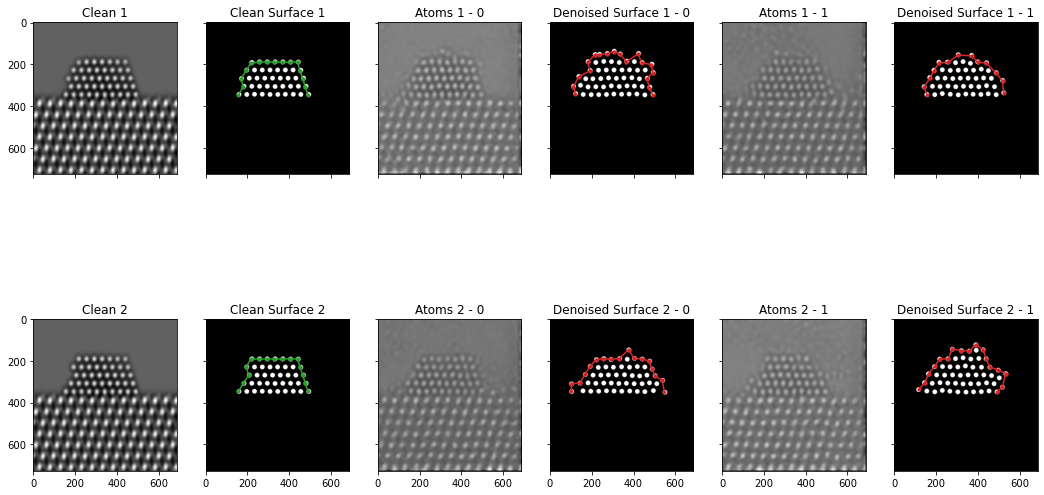

In [12]:
clean = images.cpu().detach().numpy()

fig, axes = plt.subplots(2, 6, figsize=(18, 10), sharex=True, sharey=True)
for i, j in enumerate([1,2]):
    clean_atoms, clean_blobs = get_atom_mask(clean[j], min_sigma=8, max_sigma=8, num_sigma=1, threshold=0.02)
    clean_surface, clean_rest, clean_points, clean_edges = find_boundaries(clean_blobs)

    denoised_atoms_0, denoised_blobs_0 = get_atom_mask(denoised[j, 0], min_sigma=8, max_sigma=8, num_sigma=1, threshold=0.0145)
    denoised_surface_0, denoised_rest_0, denoised_points_0, denoised_edges_0 = find_boundaries(denoised_blobs_0)

    denoised_atoms_1, denoised_blobs_1 = get_atom_mask(denoised[j, 2], min_sigma=8, max_sigma=8, num_sigma=1, threshold=0.0145)
    denoised_surface_1, denoised_rest_1, denoised_points_1, denoised_edges_1 = find_boundaries(denoised_blobs_1)

    axes[i, 0].imshow(clean[j], cmap="gray")
    axes[i, 0].set_title(f"Clean {j}")

    axes[i, 1].imshow(clean_atoms, cmap="gray")
    for edge in clean_edges:
        axes[i, 1].plot(clean_points[edge, 0], clean_points[edge, 1], ".-", c="C2")
    axes[i, 1].set_title(f"Clean Surface {j}")

    axes[i, 2].imshow(denoised[j, 0], cmap="gray")
    axes[i, 2].set_title(f"Atoms {j} - 0")

    axes[i, 3].imshow(denoised_atoms_0, cmap="gray")
    for edge in denoised_edges_0:
        axes[i, 3].plot(denoised_points_0[edge, 0], denoised_points_0[edge, 1], ".-", c="C3")
    axes[i, 3].set_title(f"Denoised Surface {j} - 0")

    axes[i, 4].imshow(denoised[j, 1], cmap="gray")
    axes[i, 4].set_title(f"Atoms {j} - 1")

    axes[i, 5].imshow(denoised_atoms_1, cmap="gray")
    for edge in denoised_edges_1:
        axes[i, 5].plot(denoised_points_1[edge, 0], denoised_points_1[edge, 1], ".-", c="C3")
    axes[i, 5].set_title(f"Denoised Surface {j} - 1")